# Разработка фреймворка для компьютерного зрения

In [1]:
from deepface import DeepFace
import os
from scipy.spatial import distance
from PIL import Image, ImageDraw, ImageFont
import random
import pandas as pd
import numpy as np
import cv2
from deepface.detectors import FaceDetector
import time
from deepface.commons import functions
from tensorflow.keras.utils import img_to_array
import keyboard

### Поиск лица

In [3]:
# DeepFace.stream(db_path='test', source = 0, model_name='ArcFace', detector_backend = 'retinaface',distance_metric = 'euclidean_l2')

facial recognition model ArcFace is just built
Age model is just built
Gender model is just built
Emotion model is just built


Finding representations: 100%|██████████| 3/3 [00:09<00:00,  3.17s/it]


Representations stored in test/representations_arcface.pkl file.Please delete this file when you add new identities in your database.
find function lasts  10.789433240890503  seconds


In [4]:
%%time
result = DeepFace.extract_faces(
    img_path = "..\\examples\\Yarick.jpg", 
    detector_backend = 'retinaface', 
    )

CPU times: total: 3.8 s
Wall time: 1.6 s


In [3]:
import cv2
cv2.imshow('Image', (result[0]['face']))
# Ожидание нажатия клавиши
cv2.waitKey(0)

# Закрытие окна
cv2.destroyAllWindows()

### Пробуем использовать извлечённый детектор

In [28]:
img_path = "..\\examples\\Yarick.jpg" 
img = cv2.imread(img_path)
model = FaceDetector.build_model('retinaface')

In [29]:
%%time
face_objs = FaceDetector.detect_faces(model, 'retinaface', img=img, align=True)
face_objs

CPU times: total: 234 ms
Wall time: 556 ms


[(array([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         ...,
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]], dtype=uint8),
  [318, 344, 317, 462],
  0.9978116154670715)]

In [30]:
cv2.imshow('Image', face_objs[0][0])
# Ожидание нажатия клавиши
cv2.waitKey(0)
# Закрытие окна
cv2.destroyAllWindows()

### Определим человека на видеопотоке

In [2]:
import tensorflow as tf
print(tf.test.is_gpu_available())
print(tf.__version__)

True
2.10.0


In [2]:
def ectract_face(face_objs):
    extracted_faces = []
    grayscale = False
    target_size = (112, 112)
    for current_img, current_region, confidence in face_objs:
        if current_img.shape[0] > 0 and current_img.shape[1] > 0:
            if grayscale is True:
                current_img = cv2.cvtColor(current_img, cv2.COLOR_BGR2GRAY)

            # resize and padding
            if current_img.shape[0] > 0 and current_img.shape[1] > 0:
                factor_0 = target_size[0] / current_img.shape[0]
                factor_1 = target_size[1] / current_img.shape[1]
                factor = min(factor_0, factor_1)

                dsize = (
                    int(current_img.shape[1] * factor),
                    int(current_img.shape[0] * factor),
                )
                current_img = cv2.resize(current_img, dsize)

                diff_0 = target_size[0] - current_img.shape[0]
                diff_1 = target_size[1] - current_img.shape[1]
                if grayscale is False:
                    # Put the base image in the middle of the padded image
                    current_img = np.pad(
                        current_img,
                        (
                            (diff_0 // 2, diff_0 - diff_0 // 2),
                            (diff_1 // 2, diff_1 - diff_1 // 2),
                            (0, 0),
                        ),
                        "constant",
                    )
                else:
                    current_img = np.pad(
                        current_img,
                        (
                            (diff_0 // 2, diff_0 - diff_0 // 2),
                            (diff_1 // 2, diff_1 - diff_1 // 2),
                        ),
                        "constant",
                    )

            # double check: if target image is not still the same size with target.
            if current_img.shape[0:2] != target_size:
                current_img = cv2.resize(current_img, target_size)

            # normalizing the image pixels
            # what this line doing? must?
            img_pixels = img_to_array(current_img)
            img_pixels = np.expand_dims(img_pixels, axis=0)
            img_pixels /= 255  # normalize input in [0, 1]

            # int cast is for the exception - object of type 'float32' is not JSON serializable
            region_obj = {
                "x": int(current_region[0]),
                "y": int(current_region[1]),
                "w": int(current_region[2]),
                "h": int(current_region[3]),
            }

            extracted_face = [img_pixels, region_obj, confidence]
            extracted_faces.append(extracted_face)

    return extracted_faces

In [6]:
model_back = FaceDetector.build_model('retinaface')
cap = cv2.VideoCapture(0)  # webcam
data = pd.read_parquet('persons.parquet', engine='pyarrow')
model_emb = DeepFace.build_model('ArcFace')
target_size = (112, 112)

def l2_normalize(x):
    return x / np.sqrt(np.sum(np.multiply(x, x)))


def get_id(img_objs, model, data):
    names = {
        1: 'Yaroslav'
    }

    detections_peoples = {'id': [], 'coords': []}
    for img, region, confidence in img_objs:
        # custom normalization
        img = functions.normalize_input(img=img, normalization='base')
        embedding = model.predict(img, verbose=0)[0].tolist()

        data['distance'] = data['embedding'].apply(lambda x: distance.euclidean(x, l2_normalize(embedding)))
        # Найденный человек и его id в формате [id]
        person_id = data.loc[(data['distance']<1.15) & (data['distance']==data['distance'].min())]['id'].to_list()
        # display(data.loc[(data['distance']<4.15) & (data['distance']==data['distance'].min())])
        data.drop(columns=['distance'], inplace=True)
        
        # если человека в базе нет
        if not person_id:
            detections_peoples['id'].append(f"undefind")
            detections_peoples['coords'].append(region)

        # если человека в базе есть
        else:
            # detections_peoples['id'].append(f"person_{person_id[0]}")
            detections_peoples['id'].append(names.get(person_id[0], f"{person_id[0]}"))
            detections_peoples['coords'].append(region)
    return detections_peoples


while True:
    _, img = cap.read()
    # print(img.shape)
    img =  cv2.resize(img, (320, 240))
    # print(img.shape)
    # raw_img = img.copy()
    # resolution_x = img.shape[1]
    # resolution_y = img.shape[0]
    start_time = time.time()
    img_objs = FaceDetector.detect_faces(model_back, 'retinaface', img=img, align=True)
    if img_objs:
        # print(img_objs[0][0].shape)
        img_objs = ectract_face(img_objs)

        # plot_img(img_objs[0][0])
        id_obj = get_id(img_objs, model_emb, data)
        
        # print('Лицо найдено. ', f'Прошло времени {time.time() - start_time}')
        for i, all_coords in enumerate(id_obj['coords']):
            coords = list(all_coords.values())
            cv2.rectangle(img, (coords[0], coords[1]), (coords[0]+coords[2], coords[1]+coords[3]), (0, 255, 0), 2)
            cv2.putText(img, id_obj['id'][i], (coords[0], coords[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            
        cv2.imshow("img", img)
        # print('Лицо есть', f'Прошло времени {time.time() - start_time}')
    else:
        # print('Лица нет', f'Прошло времени {time.time() - start_time}')
        cv2.imshow("img", img)
    
    # cv2.imshow("img", img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()   
        break


    if keyboard.is_pressed('q'):  # press q to quit
        cap.release()
        cv2.destroyAllWindows()   
        break

### Аналитика по изображению

In [4]:
result = DeepFace.analyze(
    img_path = "..\\examples\\Yarick.jpg", 
    actions=['age', 'gender', 'race', 'emotion'],
    detector_backend = 'retinaface', 
    )
result

facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: C:\Users\ykolt\.deepface\weights\facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:02<00:00, 2.14MB/s]


age_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5
To: C:\Users\ykolt\.deepface\weights\age_model_weights.h5
100%|██████████| 539M/539M [06:17<00:00, 1.43MB/s] 


gender_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5
To: C:\Users\ykolt\.deepface\weights\gender_model_weights.h5
100%|██████████| 537M/537M [01:04<00:00, 8.36MB/s] 


race_model_single_batch.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/race_model_single_batch.h5
To: C:\Users\ykolt\.deepface\weights\race_model_single_batch.h5
100%|██████████| 537M/537M [00:54<00:00, 9.93MB/s] 
Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


[{'age': 29,
  'region': {'x': 319, 'y': 344, 'w': 316, 'h': 462},
  'gender': {'Woman': 0.18113600090146065, 'Man': 99.81886744499207},
  'dominant_gender': 'Man',
  'race': {'asian': 5.028108134865761,
   'indian': 3.0811158940196037,
   'black': 0.878790020942688,
   'white': 45.757922530174255,
   'middle eastern': 19.92960423231125,
   'latino hispanic': 25.3244549036026},
  'dominant_race': 'white',
  'emotion': {'angry': 0.8976480923593044,
   'disgust': 0.0006849432338640327,
   'fear': 3.633444756269455,
   'happy': 0.8925965987145901,
   'sad': 2.678946405649185,
   'surprise': 0.31186474952846766,
   'neutral': 91.58481955528259},
  'dominant_emotion': 'neutral'}]

In [4]:
result = DeepFace.analyze(
    img_path = "..\\examples\\Yarick_v2.jpg",
    actions=['age', 'gender', 'race', 'emotion'],
    detector_backend = 'retinaface', 
)
result

Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  6.54it/s]


[{'age': 23,
  'region': {'x': 986, 'y': 252, 'w': 500, 'h': 689},
  'gender': {'Woman': 0.4333595745265484, 'Man': 99.56663846969604},
  'dominant_gender': 'Man',
  'race': {'asian': 0.2555438317358494,
   'indian': 0.40113721042871475,
   'black': 0.04701849247794598,
   'white': 68.82495284080505,
   'middle eastern': 13.881948590278625,
   'latino hispanic': 16.58940613269806},
  'dominant_race': 'white',
  'emotion': {'angry': 2.370544895529747,
   'disgust': 0.04561023670248687,
   'fear': 6.133944168686867,
   'happy': 41.9373482465744,
   'sad': 3.824266791343689,
   'surprise': 0.28525814414024353,
   'neutral': 45.40303349494934},
  'dominant_emotion': 'neutral'}]

### Сходство двух изображений

In [4]:
result = DeepFace.verify(
    img1_path = "..\\examples\\Yarick.jpg",
    img2_path = "..\\examples\\Yarick_v2.jpg",
    model_name='ArcFace',
    detector_backend = 'retinaface',
    distance_metric='euclidean_l2'
)
result

{'verified': True,
 'distance': 0.797080456399059,
 'threshold': 1.13,
 'model': 'ArcFace',
 'detector_backend': 'retinaface',
 'similarity_metric': 'euclidean_l2',
 'facial_areas': {'img1': {'x': 318, 'y': 344, 'w': 317, 'h': 462},
  'img2': {'x': 986, 'y': 252, 'w': 500, 'h': 689}},
 'time': 3.22}

### Поиск человека на изображениях в какой-то папке

In [4]:
result = DeepFace.find(
    img_path = "..\\examples\\Yarick.jpg",
    db_path = 'examples',
    model_name = 'ArcFace',
    enforce_detection = False,
    distance_metric='euclidean'
)
os.remove("..\\examples\\representations_arcface.pkl")
result = result[0]
# result.drop_duplicates(subset=['identity'], keep='first', inplace=True)
result

Finding representations: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


Representations stored in examples/representations_arcface.pkl file.Please delete this file when you add new identities in your database.
find function lasts  7.475730895996094  seconds


,identity,source_x,source_y,source_w,source_h,ArcFace_euclidean
0,examples/Yarick.jpg,303,373,398,398,0.000000
1,examples/my_team.jpg,303,373,398,398,3.349577
2,examples/Ksusha_Yar.jpg,303,373,398,398,3.385817
3,examples\Ksusha/test_1.jpg,303,373,398,398,3.752016


### Получение embedding значения по лицу

In [3]:
embedding_objs_1 = DeepFace.represent(
    img_path = "..\\examples\\Yarick.jpg",
    detector_backend = 'retinaface',
    model_name='ArcFace'
)

embedding_objs_2 = DeepFace.represent(
    img_path = "..\\examples\\Yarick_v2.jpg",
    detector_backend = 'retinaface', 
    model_name='ArcFace'
)

In [91]:
# x y w h
coords_1 = list(embedding_objs_1[0]['facial_area'].values())
coords_1 = [coords_1[0], coords_1[1], coords_1[0]+coords_1[2], coords_1[1]+coords_1[3]]
coords_1

[319, 344, 635, 806]

### Выделение лиц на изображениях

In [93]:
image = Image.open(f"..\\examples\\Yarick.jpg")
color = (random.randint(0, 255),random.randint(0, 255),random.randint(0, 255))
draw = ImageDraw.Draw(image)
draw.rectangle(tuple(coords_1), outline=color, width = 5)
    
image.show()

### Пример подсчёта евклидова расстояния 
* 'threshold' = 4.15 `для схожести предложенный DeepFace`

In [69]:
eu_distance = distance.euclidean(embedding_objs_1[0]['embedding'] ,embedding_objs_2[0]['embedding'])
eu_distance

2.983515922074877

### Вывод
Работает в целом неплохо, но есть некоторые неточности.

Лучшие параметры:
* detector_backend = `retinaface` модель детекции лица (лучшая так как хорошо вырезает лицо)
* model_name = `ArcFace` данная модель даёт лучший embedding
* distance_metric = `euclidean_l2`расстояние которое оценивается для схожести лиц в embedding
* enforce_detection = `False` для вывода исключения если лицо не найдено (проблема в том что выдаёт левые координаты)

### Типы расстояний
[Примеры расстояний в ML](https://evogeek.ru/articles/201126/)

### Напишем свой метод для детекции объектов и анализа

In [146]:
emb = DeepFace.represent (
    img_path = "..\\examples\\my_team.jpg",
    detector_backend = 'retinaface',
    model_name='ArcFace',
)
emb[0].keys()

dict_keys(['embedding', 'facial_area'])

In [131]:
len(emb[0]['embedding'])

512

### Сохраним данные об одном человеке в датафрейм и загрузим в паркет

In [147]:
data = pd.DataFrame({'id': [i for i in range(len(emb))], 'embedding': [list(val['embedding']) for val in emb]})
data.to_parquet('persons.parquet', index=False, engine='pyarrow')

In [81]:
data = pd.read_parquet('persons.parquet')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         5 non-null      int64 
 1   embedding  5 non-null      object
dtypes: int64(1), object(1)
memory usage: 208.0+ bytes


In [66]:
# Берём 0 эмбединг
# data['embedding'].to_list()

In [93]:
pd.DataFrame({'id':[], 'embedding': []}).empty #['embedding'].apply(lambda x: x+1)

True

#### Заметка
[код библиотеки](https://github.com/serengil/deepface/blob/master/deepface/DeepFace.py#L325)

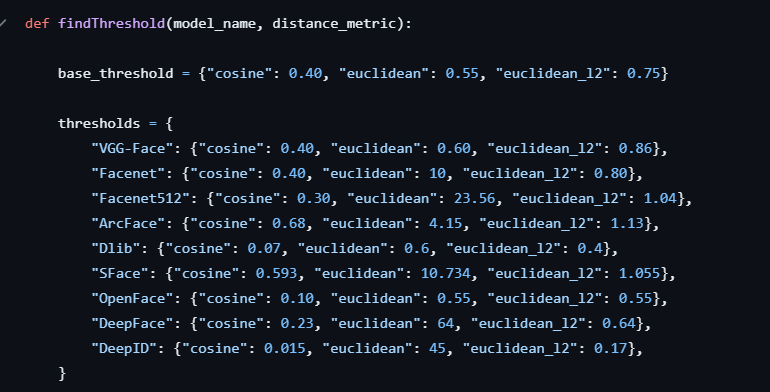

In [9]:
%%time
def plot_image(img_path, coords_for_each_person, labels):
    image = Image.open(img_path)
    font = ImageFont.truetype(size = 50, font = "arial.ttf")
    
    for i, coords in enumerate(coords_for_each_person):
        coords = [coords[0], coords[1], coords[0]+coords[2], coords[1]+coords[3]]
        color = (random.randint(0, 255),random.randint(0, 255),random.randint(0, 255))
        draw = ImageDraw.Draw(image)
        draw.text((coords[0], coords[1]-50), f"{labels[i]}", font = font, fill=color)
        draw.rectangle(coords, outline=color, width = 8)
    # image.save('image\\output_2.jpg')     
    image.show()
    

def l2_normalize(x):
    return x / np.sqrt(np.sum(np.multiply(x, x)))


def analize_faces (img_path, new_person = False, plot = True):
    data = {}
    try:
        objects = DeepFace.represent(
            img_path = img_path,
            detector_backend = 'retinaface',
            model_name='ArcFace'
        )


        # Получаем координаты всех лиц в формате List[List[x, y, w, h], List[x, y, w, h]], где
        # x, y - координаты левого верхнего угла рамки лица
        # w, h - высота и ширина рамки

        coords = [list(val['facial_area'].values()) for val in objects]
        embeddings = [list(val['embedding']) for val in objects]
        labels = []

        try:
            data = pd.read_parquet('persons.parquet', engine='pyarrow')
        except:
            data = pd.DataFrame({'id':[], 'embedding': []})

        # Словарь с выходными данными
        detections_peoples = {'id':[], 'coords':[]}

        if new_person:
            if not data.empty: # Если база данных не пустая
                for i, emb in enumerate(embeddings):
                    data['distance'] = data['embedding'].apply(lambda x: distance.euclidean(x, l2_normalize(emb)))

                    # Найденный человек и его id в формате [id]
                    person_id = data.loc[(data['distance']<1.15) & (data['distance']==data['distance'].min())]['id'].to_list()
                    # display(data.loc[(data['distance']<4.15) & (data['distance']==data['distance'].min())])
                    data.drop(columns=['distance'], inplace=True)
                    
                    # если человека в базе нет
                    if not person_id:
                        # print(f"person_{data['id'].max()+1}")
                        labels.append(f"person_{data['id'].max()+1}")
                        detections_peoples['id'].append(f"person_{data['id'].max()+1}")
                        detections_peoples['coords'].append(coords[i])

                        new_row = pd.DataFrame({'id': [data['id'].max()+1], 'embedding': [l2_normalize(emb)]})
                        data = pd.concat([data, new_row])

                        
                        # display(data)

                    # если человека в базе есть
                    else:
                        labels.append(f"person_{person_id[0]}")
                        detections_peoples['id'].append(f"person_{person_id[0]}")
                        detections_peoples['coords'].append(coords[i])

            else: # Если база данных пустая
                for i, emb in enumerate(embeddings):
                    new_row = pd.DataFrame({'id': [i], 'embedding': [l2_normalize(emb)]})
                    data = pd.concat([data, new_row])
                    
                    labels.append(f"person_{i}")
                    detections_peoples['id'].append(f"person_{i}")
                    detections_peoples['coords'].append(coords[i])

                data['id'] = data['id'].astype(int)
                # display(data)

            # Сохраняем изменения
            # display(data)
            data.to_parquet('persons.parquet', index=False, engine='pyarrow')

        else: # Без добавления в базу данных
            if not data.empty: # Если база данных не пустая
                
                for i, emb in enumerate(embeddings):
                    data['distance'] = data['embedding'].apply(lambda x: distance.euclidean(x, l2_normalize(emb)))
                    # Найденный человек и его id в формате [id]
                    person_id = data.loc[(data['distance']<1.15) & (data['distance']==data['distance'].min())]['id'].to_list()
                    # display(data.loc[(data['distance']<4.15) & (data['distance']==data['distance'].min())])
                    # display(data)
                    data.drop(columns=['distance'], inplace=True)
                    
                    # если человека в базе нет
                    if not person_id:
                        labels.append(f"undefind_{i}")
                        detections_peoples['id'].append(f"undefind_{i}")
                        detections_peoples['coords'].append(coords[i])

                    # если человека в базе есть
                    else:
                        # print(f'Человек в базе есть {person_id[0]}')
                        labels.append(f"person_{person_id[0]}")
                        detections_peoples['id'].append(f"person_{person_id[0]}")
                        detections_peoples['coords'].append(coords[i])

            else: # Если база данных пустая
                for i, emb in enumerate(embeddings):
                    labels.append(f"undefind_{i}")
                    detections_peoples['id'].append(f"undefind_{i}")
                    detections_peoples['coords'].append(coords[i])


        if plot:
            plot_image(img_path, coords, labels)
        

    except Exception as e:
        print(f'Ошибка \n\n{e}')

    return detections_peoples

# analize_faces('..\\examples\\skala_1.png', new_person=True)
analize_faces('..\\examples\\skala_2.jpg', new_person=False)
# 

# analize_faces('..\\examples\my_team.jpg', new_person=True, plot=True)
# analize_faces('..\\examples\\Yarick.jpg', new_person=True)
# analize_faces('..\\examples\\Danil.jpg', new_person=True)
# analize_faces('..\\examples\\chelicki.jpg', new_person=False)
# analize_faces('..\\examples\\disa.jpg', new_person=False)
# analize_faces('..\\examples\\Yarick_v2.jpg', new_person=False)
# analize_faces('..\\examples\\Yarick_v3.jpg', new_person=False)
# analize_faces('..\\examples\\test.png', new_person=True)
# analize_faces('..\\examples\\test_2.png', new_person=False)
# analize_faces('..\\examples\\Ksusha\\test_2.jpg', new_person=True)

CPU times: total: 438 ms
Wall time: 4.57 s


{'id': ['person_0', 'undefind_1'],
 'coords': [[562, 68, 132, 183], [817, 75, 131, 182]]}